In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from Adaboost import *
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_csv('spambase.data', header = None)

In [3]:
names = pd.read_csv('spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')

In [4]:
df.columns = col_names

In [5]:
df['Spam'] = df['Spam'] * 2 - 1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'Spam').values, df['Spam'].values, train_size = 3065, random_state = 2)

In [7]:
df['Spam'].unique()

array([ 1, -1])

In [13]:
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,-1
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,-1
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,-1
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,-1


In [14]:
ab = Adaboost()
ab.fit(X_train, y_train, t = 400)

In [15]:
# Predict on test set
y_pred = ab.predict(X_test)
print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

The ROC-AUC score of the model is: 0.9399


In [16]:
ab_sk = AdaBoostClassifier(n_estimators = 400) 
ab_sk.fit(X_train, y_train)
y_pred_sk = ab_sk.predict(X_test)
print('The ROC-AUC score of the sk-learn model is:', round(roc_auc_score(y_test, y_pred_sk), 4))

The ROC-AUC score of the sk-learn model is: 0.9279


## Training Error:

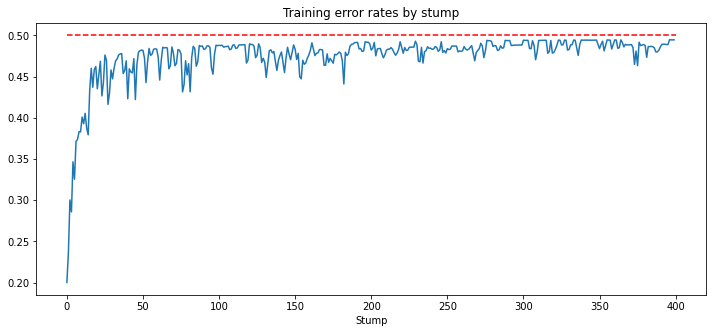

In [17]:
plt.figure(figsize=(12,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

In [18]:
def calculate_error(h_x, y, w_i):
    return (sum(w_i * (np.not_equal(y, h_x)).astype(int)))/sum(w_i)

In [19]:
print('Error rate:', round(calculate_error(y_test, y_pred, np.ones(len(y_test))), 4))

Error rate: 0.056
